In [2]:
%load_ext autoreload
%autoreload 2
import sys
# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [3]:
from pynhd import NLDI
import pygeohydro as gh
from pygeohydro import plot
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import os
import cfgrib
from datetime import datetime, timedelta, date
import cartopy.crs as crs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
import rasterio
import matplotlib as mpl
import dask.dataframe as dd
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors as mcolors
from array import array
from shapely.geometry import Polygon
import json
from shapely.geometry import Polygon, mapping
import py3dep as pp
import statistics 
from matplotlib import cm
import matplotlib.patches as mpatches
from scipy.stats import skew
from src.plotting_scripts import landtype

Matplotlib created a temporary config/cache directory at /tmp/tmp.yNYwuhhUjg/matplotlib-052fmayr because the default path (/home/aevans/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


- https://www.mrlc.gov/data/nlcd-2019-land-cover-conus 
- https://www.mrlc.gov/data/legends/national-land-cover-database-class-legend-and-description 

## Create a DF for Mesonet

In [4]:

# This will return the most recent data avail on mesonet 
# this is my file path
mesonet_data_path = '/home/aevans/nysm/archive/nysm/netcdf/proc'


# sort years
# find most recent year
dir_Year = os.listdir(f"{mesonet_data_path}")
data_point_Year = dir_Year[-1]
print(dir_Year)

# find most recent month
dir_Month = os.listdir(f"{mesonet_data_path}/{data_point_Year}")
data_point_Month = dir_Month[-1]

#this is your most recent directory
#don't use 'dir' because it will list attributes
dir1 = os.listdir(f"{mesonet_data_path}/{data_point_Year}/{data_point_Month}")

# this will give me the most recent data point
data_point = dir1[-1]

# this will return the year of the most recent data point
new_year = data_point[0:4]

# this will return the month of the most recent datapoint
new_month = data_point[4:6]

# this will return the day of the most recent datapoint
new_day = data_point[6:8]

['2020', '2019', '2022', '2018', '2017', '.keep', '2016', '2015', '2023', '2021']


In [5]:
# most recent year
dir_Year = os.listdir(f"{mesonet_data_path}")
sort_dir_Year = sorted(dir_Year)
data_point_Year = sort_dir_Year[-1]

In [6]:
# find most recent month
dir_Month = os.listdir(f"{mesonet_data_path}/{data_point_Year}")
sort_dir_Month = sorted(dir_Month)
data_point_Month = sort_dir_Month[-1]

In [7]:
# this is your directory for most recent year and month 
most_recent = os.listdir(f"{mesonet_data_path}/{data_point_Year}/{data_point_Month}")

In [8]:
# most recent datapoint
sort_most_recent = sorted(most_recent)
data_point = sort_most_recent[-1]

In [9]:
# this will return the year of the most recent data point
new_year = data_point[0:4]

In [10]:
# this will return the month of the most recent datapoint
new_month = data_point[4:6]

In [11]:
# this will return the day of the most recent datapoint
new_day = data_point[6:8]

In [12]:
# create Mesonet DataFrame

# year
year = new_year

# month
month = new_month

# day
day = new_day

# file path
file = year+month+day+'.nc'

mesonet_df = xr.open_dataset(f"{mesonet_data_path}/{year}/{month}/{file}").to_dataframe().reset_index()

In [13]:
mesonet_df

,station,time_5M,lat,lon,elev,tair,ta9m,tslo,relh,srad,...,ts05,ts25,ts50,sm05,sm25,sm50,frozen05,frozen25,frozen50,snow_depth
0,ADDI,2023-01-18 00:00:00,42.040359,-77.237259,507.614014,3.885457,4.373254,4.011158,97.480988,0.000315,...,0.8,2.2,3.24,0.528,0.440,0.429,0.0,0.0,0.0,0.040271
1,ADDI,2023-01-18 00:05:00,42.040359,-77.237259,507.614014,3.616610,4.285655,3.683252,97.385597,0.000523,...,0.8,2.2,3.28,0.528,0.439,0.429,0.0,0.0,0.0,0.040143
2,ADDI,2023-01-18 00:10:00,42.040359,-77.237259,507.614014,3.655571,4.359848,3.679820,97.672951,0.000577,...,0.8,2.2,3.22,0.528,0.440,0.429,0.0,0.0,0.0,0.042029
3,ADDI,2023-01-18 00:15:00,42.040359,-77.237259,507.614014,3.683055,4.363631,3.735792,97.838127,0.000553,...,0.8,2.2,3.22,0.530,0.439,0.429,0.0,0.0,0.0,0.040932
4,ADDI,2023-01-18 00:20:00,42.040359,-77.237259,507.614014,3.664651,4.303430,3.755347,97.871758,0.000275,...,0.8,2.2,3.22,0.531,0.439,0.429,0.0,0.0,0.0,0.040992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36283,YORK,2023-01-18 23:35:00,42.855042,-77.847763,177.942001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36284,YORK,2023-01-18 23:40:00,42.855042,-77.847763,177.942001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36285,YORK,2023-01-18 23:45:00,42.855042,-77.847763,177.942001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36286,YORK,2023-01-18 23:50:00,42.855042,-77.847763,177.942001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
current_time_df = mesonet_df.dropna(subset=['tair'])

last_value = current_time_df['time_5M'].iat[-1]
hour = last_value.hour
minute = last_value.minute
second = last_value.second

string_hour = str(hour)
string_minute = str(minute)
string_sec = str(second)

#time
time = string_hour+':'+string_minute+':'+string_sec
mesonet_df.reset_index(inplace=True)

# creating a new dataframe that is centered on the location in the dataframe
mesonet_single_datetime_df = mesonet_df.loc[mesonet_df['time_5M']==f"{year}-{month}-{day} {time}"] 
mesonet_single_datetime_df

,index,station,time_5M,lat,lon,elev,tair,ta9m,tslo,relh,...,ts05,ts25,ts50,sm05,sm25,sm50,frozen05,frozen25,frozen50,snow_depth
185,185,ADDI,2023-01-18 15:25:00,42.040359,-77.237259,507.614014,3.197313,3.262244,3.304191,77.151047,...,0.70,2.10,3.100000,0.554,0.440,0.429,0.0,0.0,0.0,0.032461
473,473,ANDE,2023-01-18 15:25:00,42.182270,-74.801392,518.281982,2.675057,2.472264,2.728517,85.208076,...,1.30,2.34,3.500000,0.266,0.165,0.154,0.0,0.0,0.0,0.004856
761,761,BATA,2023-01-18 15:25:00,43.019939,-78.135658,276.119995,2.751437,2.684417,2.852145,93.637497,...,1.60,1.90,3.060000,0.341,0.272,0.278,0.0,0.0,0.0,0.004450
1049,1049,BEAC,2023-01-18 15:25:00,41.528751,-73.945267,90.159798,7.646682,7.270403,7.585326,67.957047,...,3.30,3.60,4.099999,0.311,0.292,0.256,0.0,0.0,0.0,0.007896
1337,1337,BELD,2023-01-18 15:25:00,42.223221,-75.668518,470.369995,2.219410,2.173209,2.332009,94.522591,...,1.00,1.90,3.100000,0.487,0.475,0.400,0.0,0.0,0.0,0.032670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35033,35033,WFMB,2023-01-18 15:25:00,44.393234,-73.858826,614.598999,1.057347,1.053860,1.229243,84.794182,...,0.44,1.42,2.120000,0.305,0.225,0.238,0.0,0.0,0.0,0.080610
35321,35321,WGAT,2023-01-18 15:25:00,43.532410,-75.158600,442.966003,1.015621,0.974618,1.185778,98.758537,...,0.10,0.60,1.400000,0.111,0.243,0.088,0.0,0.0,0.0,0.062763
35609,35609,WHIT,2023-01-18 15:25:00,43.485073,-73.423073,36.563801,1.451534,1.253394,1.274567,93.842819,...,0.20,1.40,2.900000,0.298,0.500,0.497,0.0,0.0,0.0,0.030152
35897,35897,WOLC,2023-01-18 15:25:00,43.228680,-76.842613,121.219002,4.058668,4.008582,4.076464,89.429642,...,1.80,1.60,2.000000,0.300,0.078,0.131,0.0,0.0,0.0,-0.000167


## create lists to feed into nlcd finder

In [15]:
mesonet_single_datetime_df['longitude'] = mesonet_single_datetime_df['lon'].astype(float)
mesonet_single_datetime_df['latitude'] = mesonet_single_datetime_df['lat'].astype(float)

/tmp/tmp.yNYwuhhUjg/ipykernel_692186/518137607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mesonet_single_datetime_df['longitude'] = mesonet_single_datetime_df['lon'].astype(float)
/tmp/tmp.yNYwuhhUjg/ipykernel_692186/518137607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mesonet_single_datetime_df['latitude'] = mesonet_single_datetime_df['lat'].astype(float)


In [16]:
longitude_list = mesonet_single_datetime_df['longitude'].to_list()
latitude_list = mesonet_single_datetime_df['latitude'].to_list()

In [17]:
mesonet_lon_lat_list = []

for x,_ in enumerate(longitude_list):
    longitudes = longitude_list[x]
    latitudes = latitude_list[x]
    tuple_edit = (longitudes, latitudes)
    mesonet_lon_lat_list.append(tuple_edit)

In [18]:
mesonet_lon_lat_list

[(-77.23725891113281, 42.04035949707031),
 (-74.8013916015625, 42.18227005004883),
 (-78.13565826416016, 43.01993942260742),
 (-73.94526672363281, 41.528751373291016),
 (-75.66851806640625, 42.22322082519531),
 (-76.11373138427734, 43.78961944580078),
 (-78.03958129882812, 42.242488861083984),
 (-76.20319366455078, 42.3203010559082),
 (-75.95104217529297, 42.05842971801758),
 (-73.95367431640625, 40.63176345825195),
 (-79.02153778076172, 42.594940185546875),
 (-73.57642364501953, 41.4399299621582),
 (-77.9659194946289, 43.208351135253906),
 (-73.89352416992188, 40.87248229980469),
 (-75.2992935180664, 42.7959098815918),
 (-73.8749771118164, 43.02280044555664),
 (-78.76717376708984, 43.00017166137695),
 (-76.77175903320312, 42.41041946411133),
 (-78.74903106689453, 43.31698989868164),
 (-75.74298858642578, 43.33985137939453),
 (-76.32685852050781, 44.10451889038086),
 (-73.46460723876953, 44.89564895629883),
 (-73.77735900878906, 43.653900146484375),
 (-75.97562408447266, 42.52242279052

In [19]:
lon_lat_df = pd.DataFrame()
lon_lat_df['lon'] = longitude_list
lon_lat_df['lat'] = latitude_list

In [20]:
#lon_lat_df.to_csv('nysm_coords.csv')

In [21]:
lulc = gh.nlcd_bycoords(mesonet_lon_lat_list).set_crs(epsg=4326)
lulc

,geometry,canopy_2016,impervious_2019,descriptor_2019,cover_2019
0,POINT (-77.23726 42.04036),0.0,0.0,0,81
1,POINT (-74.80139 42.18227),0.0,0.0,0,81
2,POINT (-78.13566 43.01994),0.0,1.0,24,21
3,POINT (-73.94527 41.52875),0.0,13.0,24,21
4,POINT (-75.66852 42.22322),0.0,0.0,0,81
...,...,...,...,...,...
121,POINT (-73.85883 44.39323),19.0,1.0,24,21
122,POINT (-75.15860 43.53241),0.0,0.0,0,42
123,POINT (-73.42307 43.48507),0.0,0.0,0,81
124,POINT (-76.84261 43.22868),0.0,0.0,0,82


<AxesSubplot:ylabel='Frequency'>

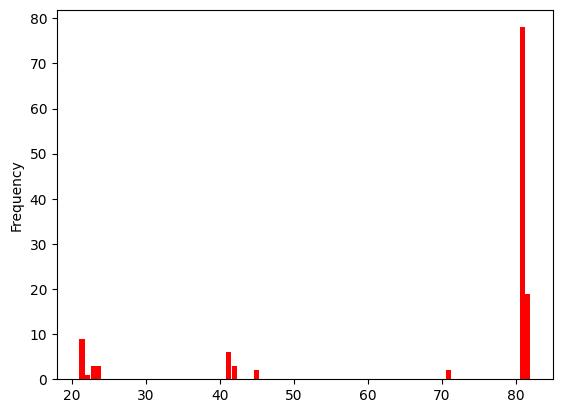

In [22]:
# # analysis on data
lulc['cover_2019'].plot.hist(bins=80,rwidth=0.9,
                    color='red')

In [23]:
lulc[['cover_2019']].describe()

,cover_2019
count,126.000000
mean,70.095238
std,21.486900
min,21.000000
25%,81.000000
50%,81.000000
75%,81.000000
max,82.000000


In [24]:
lulc['cover_2019'].mode()

0    81
Name: cover_2019, dtype: int8

In [25]:
lulc['cover_2019'].value_counts()

81    78
82    19
21     9
41     6
23     3
24     3
42     3
45     2
71     2
22     1
Name: cover_2019, dtype: int64

In [26]:
lulc['lon'] = longitude_list
lulc['lat'] = latitude_list

In [27]:
def scatterPlot(df, ax, lonW, lonE, latS, latN, fig): 
    sc = df.plot.scatter(x='lon', y='lat', c = 'color', ax=ax, zorder=5)

    ax.legend()
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='--');
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(crs=crs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='black', alpha=0.5, linestyle='--')

    # # to annotate map 
    # for k, v in df.iterrows():
    #     ax.annotate(v.nlcd,xy=(v.lon,v.lat),
    #                 xytext=(10,-5), textcoords='offset points',
    #                 family='sans-serif', fontsize=10, color='darkslategrey')

    

In [28]:
# create colormap 
colors = ['black', 'blue', 'white', 'coral', 'pink', 'red', 'magenta', 'gray', 'lime', 'forestgreen', 'green', 'olive', 'brown', 'slategray', 'darkorchid','plum', 'indigo', 'purple', 'yellow', 'gold', 'orange', 'cyan']

legend = np.array([0,11,12,21,22,23,24,31,41,42,43,45,51,52,71,72,73,74,81,82,90,95])

leg_str = ['No Data','Open Water','Perennial Ice/Snow',
'Developed, Open Space','Developed, Low Intensity', 'Developed, Medium Intensity','Developed High Intensity',
'Barren Land (Rock/Sand/Clay)',
'Deciduous Forest','Evergreen Forest','Mixed Forest', 'Forest/Shrub',
'Dwarf Scrub','Shrub/Scrub',
'Grassland/Herbaceous','Sedge/Herbaceous','Lichens','Moss',
'Pasture/Hay','Cultivated Crops',
'Woody Wetlands','Emergent Herbaceous Wetlands']

In [29]:
len(colors)
colordict={}
for x in range(22):
    colordict.update({legend[x] : colors[x]})


In [30]:
len(colors)
descripdict={}
for x in range(22):
    descripdict.update({legend[x] : leg_str[x]})

In [31]:
lulc['color'] = lulc['cover_2019'].map(colordict)
lulc['nlcd'] = lulc['cover_2019'].map(descripdict)
lulc

,geometry,canopy_2016,impervious_2019,descriptor_2019,cover_2019,lon,lat,color,nlcd
0,POINT (-77.23726 42.04036),0.0,0.0,0,81,-77.237259,42.040359,yellow,Pasture/Hay
1,POINT (-74.80139 42.18227),0.0,0.0,0,81,-74.801392,42.182270,yellow,Pasture/Hay
2,POINT (-78.13566 43.01994),0.0,1.0,24,21,-78.135658,43.019939,coral,"Developed, Open Space"
3,POINT (-73.94527 41.52875),0.0,13.0,24,21,-73.945267,41.528751,coral,"Developed, Open Space"
4,POINT (-75.66852 42.22322),0.0,0.0,0,81,-75.668518,42.223221,yellow,Pasture/Hay
...,...,...,...,...,...,...,...,...,...
121,POINT (-73.85883 44.39323),19.0,1.0,24,21,-73.858826,44.393234,coral,"Developed, Open Space"
122,POINT (-75.15860 43.53241),0.0,0.0,0,42,-75.158600,43.532410,forestgreen,Evergreen Forest
123,POINT (-73.42307 43.48507),0.0,0.0,0,81,-73.423073,43.485073,yellow,Pasture/Hay
124,POINT (-76.84261 43.22868),0.0,0.0,0,82,-76.842613,43.228680,gold,Cultivated Crops


In [32]:
new_cmap = ListedColormap(colors)

In [33]:
cmap = ListedColormap(colordict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


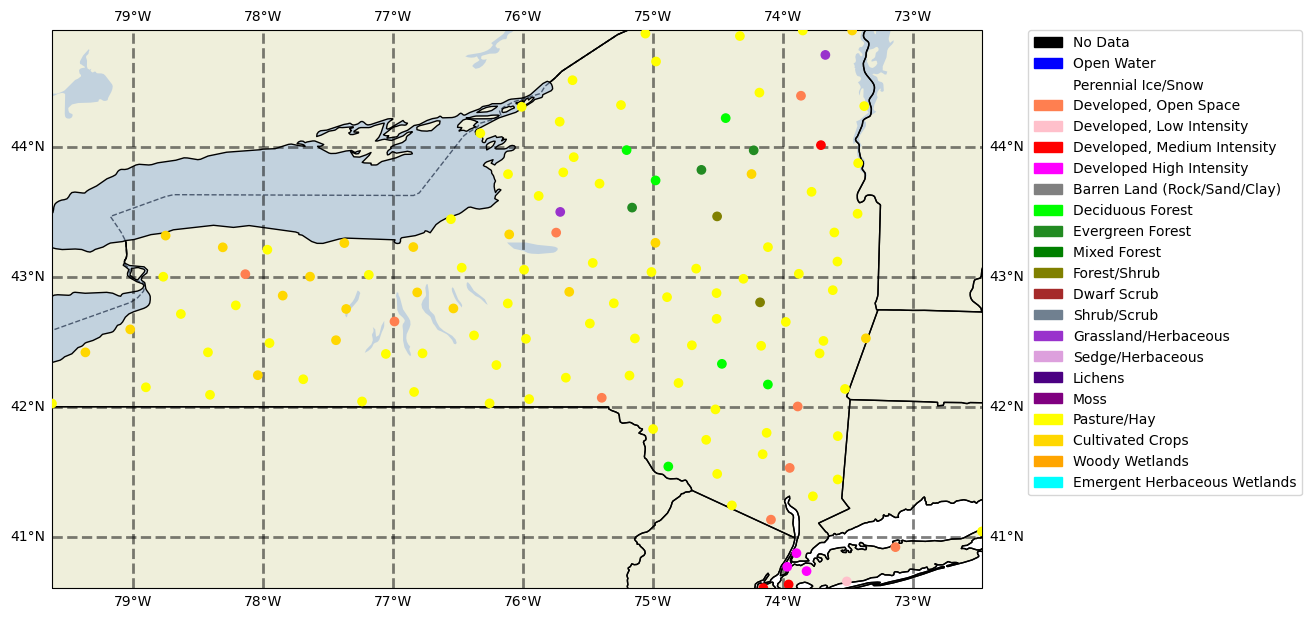

In [34]:
landtype.landtype(lulc)

In [35]:
lulc['nlcd'].value_counts()

Pasture/Hay                    78
Cultivated Crops               19
Developed, Open Space           9
Deciduous Forest                6
Developed, Medium Intensity     3
Developed High Intensity        3
Evergreen Forest                3
Forest/Shrub                    2
Grassland/Herbaceous            2
Developed, Low Intensity        1
Name: nlcd, dtype: int64

# Oklahoma

In [34]:
# create dataframe for Oklahome 
#Oklahoma_mesonet_filepath = '/home/aevans/landtype/NY_cartopy/csv_city/geoinfo.csv'
oklahoma_mesonet_df = pd.read_csv(Oklahoma_mesonet_filepath)
oklahoma_mesonet_df

,stnm,stid,name,city,rang,cdir,cnty,nlat,elon,elev,...,A75,N75,BULK75,GRAV75,SAND75,SILT75,CLAY75,TEXT75,datc,datd
0,110,ACME,Acme,Rush Springs,4.0,WNW,Grady,34.80833,-98.02325,397,...,0.178,1.32,1.68,0.0,53.2,24.1,22.8,Sandy Clay Loam,19940101,20991231
1,1,ADAX,Ada,Ada,2.0,NNE,Pontotoc,34.79851,-96.66909,295,...,0.053,1.20,1.86,0.0,43.6,26.6,29.8,Clay Loam,19940101,20991231
2,2,ALTU,Altus,Altus,3.0,S,Jackson,34.58722,-99.33808,416,...,0.059,1.16,1.73,0.0,15.0,40.9,44.1,Silty Clay,19940101,20991231
3,116,ALV2,Alva,Alva,7.2,SSW,Woods,36.70823,-98.70974,439,...,-999.000,-999.00,-999.00,-999.0,-999.0,-999.0,-999.0,-999,19981217,20991231
4,3,ALVA,Alva,Alva,2.0,S,Woods,36.77970,-98.67170,450,...,-999.000,-999.00,-999.00,-999.0,-999.0,-999.0,-999.0,-999,19940101,19981216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,105,WILB,Wilburton,Wilburton,2.0,SW,Latimer,34.90092,-95.34805,199,...,0.189,1.21,1.37,0.0,8.7,27.4,63.9,Clay,19940101,20991231
140,106,WIST,Wister,Wister,3.0,ENE,LeFlore,34.98426,-94.68778,143,...,0.096,1.16,1.44,0.0,4.4,24.9,70.8,Clay,19940101,20991231
141,107,WOOD,Woodward,Woodward,2.0,WSW,Woodward,36.42329,-99.41682,625,...,0.270,1.47,1.33,0.0,42.6,31.9,25.5,Loam,19940101,20991231
142,108,WYNO,Wynona,Wynona,2.0,S,Osage,36.51806,-96.34222,269,...,0.079,1.23,1.69,0.0,9.8,37.2,53.0,Clay,19940101,20991231


In [35]:
len(oklahoma_mesonet_df)

144

In [48]:
ok_longitude_list = oklahoma_mesonet_df['elon'].to_list()
ok_latitude_list = oklahoma_mesonet_df['nlat'].to_list()

In [49]:
ok_mesonet_lon_lat_list = []

for x,_ in enumerate(oklahoma_mesonet_df['stid']):
    longitudes = ok_longitude_list[x]
    latitudes = ok_latitude_list[x]
    tuple_edit = (longitudes, latitudes)
    ok_mesonet_lon_lat_list.append(tuple_edit)

In [50]:
ok_mesonet_lon_lat_list

[(-98.02325, 34.80833),
 (-96.66909, 34.79851),
 (-99.33808, 34.58722),
 (-98.70974, 36.70823),
 (-98.6717, 36.7797),
 (-95.66844, 34.24967),
 (-95.70059, 34.22438),
 (-98.29216, 34.91418),
 (-97.08568, 34.19258),
 (-97.085, 34.1922),
 (-99.90308, 36.07204),
 (-94.6131, 34.0144),
 (-100.53012, 36.80253),
 (-96.64386, 34.19121),
 (-99.05847, 35.40185),
 (-95.86621, 35.96305),
 (-97.25452, 36.75443),
 (-102.49713, 36.69256),
 (-96.63121, 35.17156),
 (-97.69394, 36.41201),
 (-96.35404, 35.7805),
 (-94.6244, 34.0433),
 (-99.64101, 36.83129),
 (-96.81046, 36.63459),
 (-97.26918, 33.89376),
 (-99.27059, 35.5915),
 (-97.0033, 34.8497),
 (-96.33422, 34.9924),
 (-99.34652, 36.02866),
 (-97.28585, 36.1473),
 (-95.7572, 36.2619),
 (-96.33309, 34.60896),
 (-96.80407, 35.65282),
 (-98.36274, 36.74813),
 (-99.7279, 35.54615),
 (-97.91446, 35.03236),
 (-95.6417, 36.3172),
 (-95.32596, 34.65657),
 (-95.2487, 34.22321),
 (-95.64617, 36.32112),
 (-94.84896, 35.68001),
 (-95.88553, 36.90987),
 (-96.32027

In [51]:
ok_lon_lat_df = pd.DataFrame()
ok_lon_lat_df['lon'] = ok_longitude_list
ok_lon_lat_df['lat'] = ok_latitude_list

In [52]:
#ok_lon_lat_df.to_csv('ok_coords.csv')

In [53]:
lulc2 = gh.nlcd_bycoords(ok_mesonet_lon_lat_list)
lulc2

,geometry,canopy_2016,impervious_2019,descriptor_2019,cover_2019
0,POINT (-98.02325 34.80833),0.0,0.0,0,71
1,POINT (-96.66909 34.79851),0.0,0.0,0,71
2,POINT (-99.33808 34.58722),0.0,0.0,0,82
3,POINT (-98.70974 36.70823),0.0,0.0,0,71
4,POINT (-98.67170 36.77970),0.0,0.0,0,82
...,...,...,...,...,...
139,POINT (-95.34805 34.90092),0.0,0.0,0,81
140,POINT (-94.68778 34.98426),0.0,0.0,0,81
141,POINT (-99.41682 36.42329),0.0,0.0,0,71
142,POINT (-96.34222 36.51806),0.0,0.0,0,71


<AxesSubplot:ylabel='Frequency'>

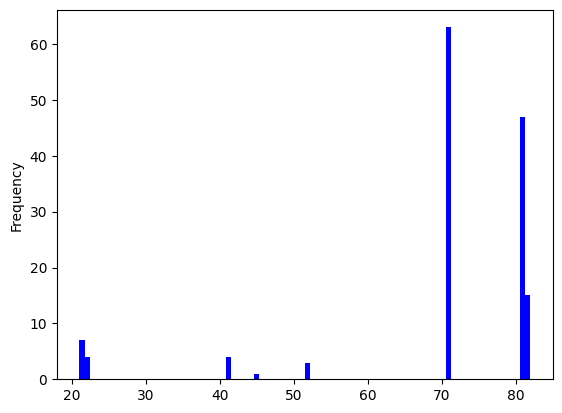

In [54]:
# # analysis on data
lulc2['cover_2019'].plot.hist(bins=80,rwidth=0.9,
                    color='blue')

In [55]:
lulc2[['cover_2019']].describe()

,cover_2019
count,144.000000
mean,70.208333
std,16.490673
min,21.000000
25%,71.000000
50%,71.000000
75%,81.000000
max,82.000000


In [56]:
lulc2['cover_2019'].mode()

0    71
Name: cover_2019, dtype: int8

In [57]:
lulc2['cover_2019'].value_counts()

71    63
81    47
82    15
21     7
41     4
22     4
52     3
45     1
Name: cover_2019, dtype: int64

In [58]:
lulc2['lon'] = ok_longitude_list
lulc2['lat'] = ok_latitude_list


In [59]:
lulc2['color'] = lulc2['cover_2019'].map(colordict)
lulc2['nlcd'] = lulc2['cover_2019'].map(descripdict)
lulc2

,geometry,canopy_2016,impervious_2019,descriptor_2019,cover_2019,lon,lat,color,nlcd
0,POINT (-98.02325 34.80833),0.0,0.0,0,71,-98.02325,34.80833,darkorchid,Grassland/Herbaceous
1,POINT (-96.66909 34.79851),0.0,0.0,0,71,-96.66909,34.79851,darkorchid,Grassland/Herbaceous
2,POINT (-99.33808 34.58722),0.0,0.0,0,82,-99.33808,34.58722,gold,Cultivated Crops
3,POINT (-98.70974 36.70823),0.0,0.0,0,71,-98.70974,36.70823,darkorchid,Grassland/Herbaceous
4,POINT (-98.67170 36.77970),0.0,0.0,0,82,-98.67170,36.77970,gold,Cultivated Crops
...,...,...,...,...,...,...,...,...,...
139,POINT (-95.34805 34.90092),0.0,0.0,0,81,-95.34805,34.90092,yellow,Pasture/Hay
140,POINT (-94.68778 34.98426),0.0,0.0,0,81,-94.68778,34.98426,yellow,Pasture/Hay
141,POINT (-99.41682 36.42329),0.0,0.0,0,71,-99.41682,36.42329,darkorchid,Grassland/Herbaceous
142,POINT (-96.34222 36.51806),0.0,0.0,0,71,-96.34222,36.51806,darkorchid,Grassland/Herbaceous


In [60]:
lulc2['lat'].max()

36.98707

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


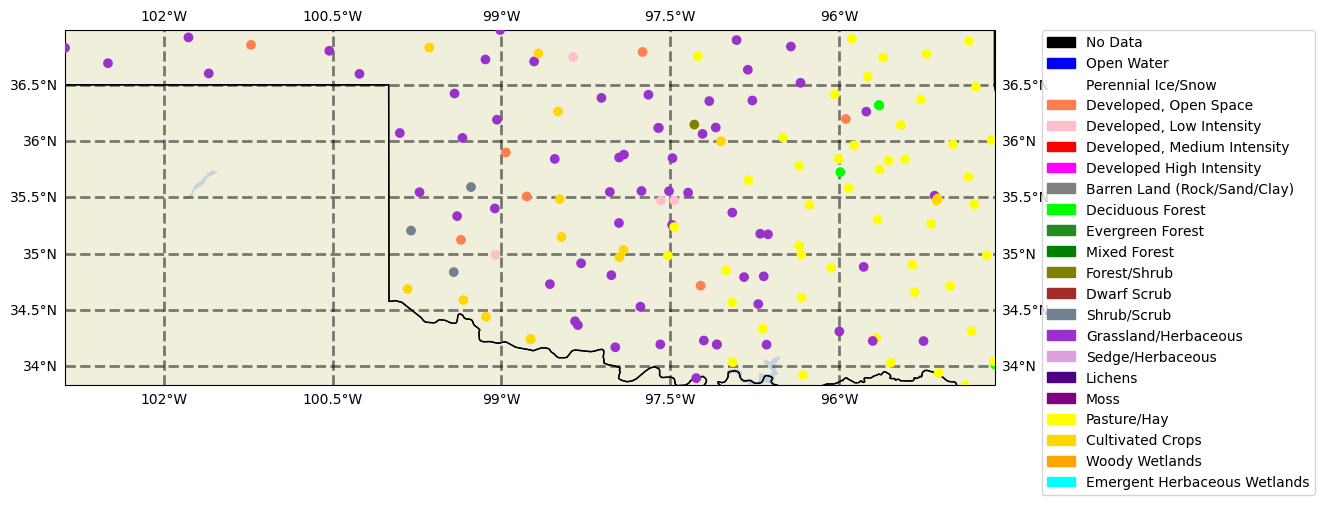

In [61]:
projPC = crs.PlateCarree()
latN = lulc2['lat'].max()
latS = lulc2['lat'].min()
lonW = lulc2['lon'].max()
lonE = lulc2['lon'].min()
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
projLccOK = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

fig, ax = plt.subplots(figsize=(12,9), subplot_kw={'projection': crs.PlateCarree()})
ax.legend()
ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='--');
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.STATES)
ax.xticklabels_top = False
ax.ylabels_right = False
ax.gridlines(crs=crs.PlateCarree(), draw_labels=True,
                linewidth=2, color='black', alpha=0.5, linestyle='--')

plt.scatter(lulc2['lon'], lulc2['lat'], c=lulc2['color'], cmap = cmap, transform=crs.PlateCarree(), zorder=5)

# legend 
patch1 = mpatches.Patch(color=colors[0], label=leg_str[0])
patch2 = mpatches.Patch(color=colors[1], label=leg_str[1])
patch3 = mpatches.Patch(color=colors[2], label=leg_str[2])
patch4 = mpatches.Patch(color=colors[3], label=leg_str[3])
patch5 = mpatches.Patch(color=colors[4], label=leg_str[4])
patch6 = mpatches.Patch(color=colors[5], label=leg_str[5])
patch7 = mpatches.Patch(color=colors[6], label=leg_str[6])
patch8 = mpatches.Patch(color=colors[7], label=leg_str[7])
patch9 = mpatches.Patch(color=colors[8], label=leg_str[8])
patch10 = mpatches.Patch(color=colors[9], label=leg_str[9])
patch11 = mpatches.Patch(color=colors[10], label=leg_str[10])
patch12 = mpatches.Patch(color=colors[11], label=leg_str[11])
patch13 = mpatches.Patch(color=colors[12], label=leg_str[12])
patch14 = mpatches.Patch(color=colors[13], label=leg_str[13])
patch15 = mpatches.Patch(color=colors[14], label=leg_str[14])
patch16 = mpatches.Patch(color=colors[15], label=leg_str[15])
patch17 = mpatches.Patch(color=colors[16], label=leg_str[16])
patch18 = mpatches.Patch(color=colors[17], label=leg_str[17])
patch19 = mpatches.Patch(color=colors[18], label=leg_str[18])
patch20 = mpatches.Patch(color=colors[19], label=leg_str[19])
patch21 = mpatches.Patch(color=colors[20], label=leg_str[20])
patch22 = mpatches.Patch(color=colors[21], label=leg_str[21])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,handles=[patch1,patch2,patch3,patch4,patch5,patch6,patch7,patch8,patch9,patch10,patch11,patch12,patch13,patch14,patch15,patch16,patch17,patch18,patch19,patch20,patch21,patch22 ])


In [106]:
lulc2['nlcd'].value_counts()

Grassland/Herbaceous        63
Pasture/Hay                 47
Cultivated Crops            15
Developed, Open Space        7
Deciduous Forest             4
Developed, Low Intensity     4
Shrub/Scrub                  3
Forest/Shrub                 1
Name: nlcd, dtype: int64

# Analysis of area within range of landtype

In [62]:
# Testing Kara's Code
#these are the buffered polygons for 28 mesonet sites in meters (epsg=3310)
lulc['geometry'].to_crs(epsg=3310).buffer(2000)

0      POLYGON ((3430736.781 1233538.716, 3430727.150...
1      POLYGON ((3604248.538 1337933.640, 3604238.907...
2      POLYGON ((3317131.507 1299464.763, 3317121.876...
3      POLYGON ((3700914.282 1306667.367, 3700904.652...
4      POLYGON ((3538261.392 1309330.572, 3538251.762...
                             ...                        
121    POLYGON ((3559030.274 1590258.884, 3559020.644...
122    POLYGON ((3509856.877 1457470.960, 3509847.247...
123    POLYGON ((3637220.482 1518214.104, 3637210.851...
124    POLYGON ((3402314.944 1366075.396, 3402305.313...
125    POLYGON ((3346263.241 1293085.180, 3346253.611...
Length: 126, dtype: geometry

In [63]:
#grab just one site as a sample - you will eventually want to loop over all the sites...
sample_geom = lulc['geometry'].to_crs(epsg=3310).buffer(20000).iloc[0]

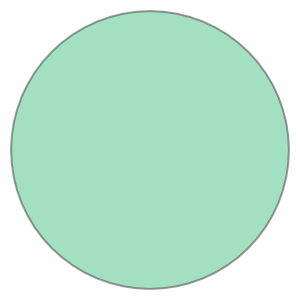

In [64]:
sample_geom

In [65]:
#individual POLYGONs in geometry column are shapely objects, so you can use .bounds method on this object to get a tuple of (minx, miny, maxx, maxy).
min_x = sample_geom.bounds[0]
min_y = sample_geom.bounds[1]
max_x = sample_geom.bounds[2]
max_y = sample_geom.bounds[3]

In [66]:
# get all points linearly spaced within min/max values at resolution of 30 m
x_array = np.linspace(min_x,max_x,30) 
y_array = np.linspace(min_y,max_y,30)

In [67]:
#now take the two X and Y arrays and create a meshgrid, so you get all of the inner points of the grid
X,Y = np.meshgrid(x_array,y_array)

In [68]:
##create dataframe from all X and Y values
all_points = pd.DataFrame({'lat':X.flatten(), 'lon':Y.flatten()})

In [69]:
all_points

,lat,lon
0,3.408737e+06,1.213539e+06
1,3.410116e+06,1.213539e+06
2,3.411495e+06,1.213539e+06
3,3.412875e+06,1.213539e+06
4,3.414254e+06,1.213539e+06
...,...,...
895,3.443220e+06,1.253539e+06
896,3.444599e+06,1.253539e+06
897,3.445978e+06,1.253539e+06
898,3.447357e+06,1.253539e+06


In [70]:
##convert the dataframe to a geopandas dataframe & make sure to assign crs as "meters" then convert to lat/lon
all_points_gdf = gpd.GeoDataFrame(
    all_points,
    geometry=gpd.points_from_xy(all_points.lat, all_points.lon),
    crs=3310 #meters
)

In [71]:
all_points_gdf.to_crs(epsg=4326,inplace=True) #change from meters to lat/lon

In [72]:
##these are all the points within the 30-km grid that surrounds the mesonet site
all_points_gdf

,lat,lon,geometry
0,3.408737e+06,1.213539e+06,POINT (-77.55892 41.95622)
1,3.410116e+06,1.213539e+06,POINT (-77.54395 41.95084)
2,3.411495e+06,1.213539e+06,POINT (-77.52898 41.94545)
3,3.412875e+06,1.213539e+06,POINT (-77.51402 41.94006)
4,3.414254e+06,1.213539e+06,POINT (-77.49906 41.93467)
...,...,...,...
895,3.443220e+06,1.253539e+06,POINT (-76.97468 42.14552)
896,3.444599e+06,1.253539e+06,POINT (-76.95972 42.14007)
897,3.445978e+06,1.253539e+06,POINT (-76.94476 42.13461)
898,3.447357e+06,1.253539e+06,POINT (-76.92980 42.12915)


In [73]:
##but, we want within 30km of the site, so we want a circle with radius, not a square...
#so lets take our original buffer and exclude any points that exist outside that buffer
sample_geom_ll = lulc['geometry'].to_crs(epsg=3310).buffer(2000).to_crs(epsg=4326).iloc[0] #original buffer but in lat/lon

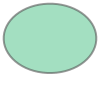

In [74]:
sample_geom_ll

In [75]:
#now, grab only the points that are within the buffer (sample_geom_ll)
all_points_in_buffer_gdf = all_points_gdf.loc[all_points_gdf['geometry'].within(sample_geom_ll)==True].reset_index(drop=True)

In [76]:
##these are your points!
all_points_in_buffer_gdf

,lat,lon,geometry
0,3.428047e+06,1.232849e+06,POINT (-77.24836 42.03747)
1,3.429426e+06,1.232849e+06,POINT (-77.23340 42.03205)
2,3.428047e+06,1.234228e+06,POINT (-77.24112 42.04867)
3,3.429426e+06,1.234228e+06,POINT (-77.22615 42.04325)


In [77]:
get_coords = all_points_in_buffer_gdf['geometry']

<AxesSubplot:>

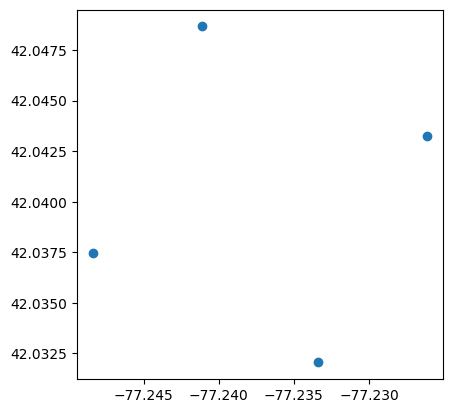

In [78]:
get_coords.plot()

In [79]:
nlcd_analysis_list_1 = []
lulc_geo_1 = gpd.GeoSeries(lulc['geometry'])
analysis_df_2 = pd.DataFrame()
lon_lat_list_2 = []

In [80]:
my_length = len(get_coords) - 1

In [81]:
xx, yy = get_coords[my_length].coords.xy
analysis_df_2['lon'] = xx
analysis_df_2['lat'] = yy
longitude_list_analysis_1 = analysis_df_2['lon'].to_list()
latitude_list_analysis_1 = analysis_df_2['lat'].to_list()

In [82]:
new_longitudes = longitude_list_analysis_1[0]
new_latitudes = latitude_list_analysis_1[0]
tuple_edit = (new_longitudes, new_latitudes)
lon_lat_list_2.append(tuple_edit)

In [83]:
my_nlcd_list = []
lulc_geo_1 = gpd.GeoSeries(lulc['geometry'])
anal_df = pd.DataFrame()
lon_lat_list_3 = []
lon_list = []
lat_list = []

for i in range(my_length):
    xx, yy = get_coords[i].coords.xy
    anal_df['lon'] = xx
    anal_df['lat'] = yy
    longitude_list_analysis_2 = anal_df['lon'].to_list()
    latitude_list_analysis_2 = anal_df['lat'].to_list()
    my_lon = longitude_list_analysis_2[0]
    my_lat = latitude_list_analysis_2[0]
    tuple_edit = (my_lon, my_lat)
    lon_lat_list_3.append(tuple_edit)
    lon_list.append(my_lon)
    lat_list.append(my_lat)

#print(len(latitude_list_analysis_2))
# longitudes_1 = longitude_list_analysis_2[i]
# latitudes_1 = latitude_list_analysis_2[i]
# tuple_edit = (longitudes_1, latitudes_1)
# lon_lat_list_3.append(tuple_edit)


In [84]:
lon_lat_list_4 = []

for i in range(my_length):
    xx, yy = get_coords[i].coords.xy
    my_lon = xx[0]
    my_lat = yy[0]
    tuple_edit = (my_lon, my_lat)
    lon_lat_list_4.append(tuple_edit)

In [85]:
lon_lat_list_4

[(-77.24836323720012, 42.037471707319675),
 (-77.23340158434198, 42.03204824689401),
 (-77.24111714163509, 42.04867072725493)]

In [86]:
anal_df1 = pd.DataFrame()
anal_df1['lons'] = lon_list
anal_df1['lats'] = lat_list
anal_df1

,lons,lats
0,-77.248363,42.037472
1,-77.233402,42.032048
2,-77.241117,42.048671


In [87]:
def scatterPlot(df, ax, lonW, lonE, latS, latN, fig): 
    sc = df.plot.scatter(x='lons', y='lats', c = 'r', ax=ax, zorder=5)

    ax.legend()
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='--');
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(crs=crs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='black', alpha=0.5, linestyle='--')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


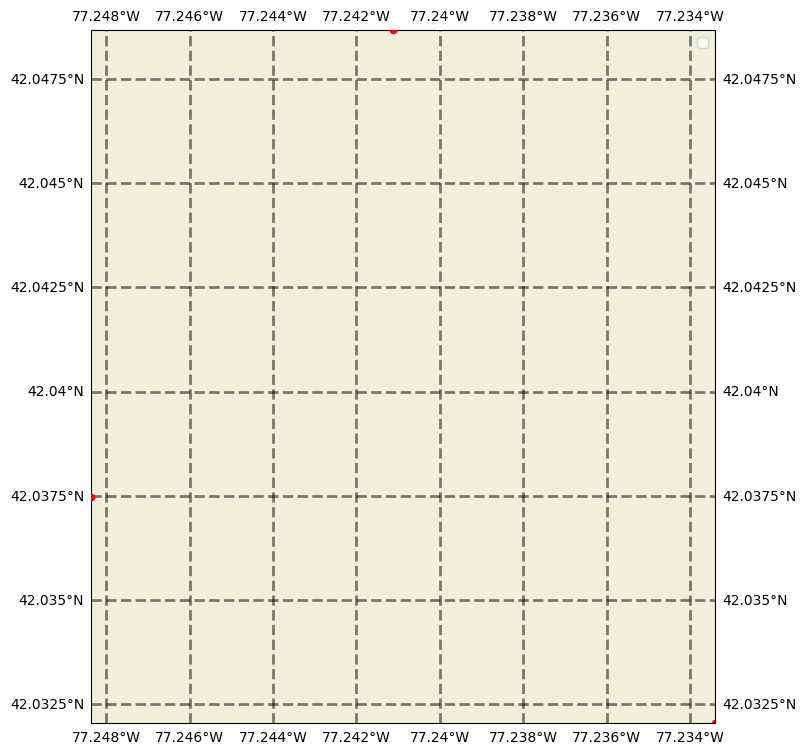

In [88]:
projPC = crs.PlateCarree()
latN = anal_df1['lats'].max()
latS = anal_df1['lats'].min()
lonW = anal_df1['lons'].max()
lonE = anal_df1['lons'].min()
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
projLccNY = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

fig, ax = plt.subplots(figsize=(12,9), subplot_kw={'projection': crs.PlateCarree()})

scatterPlot(anal_df1, ax, lonW, lonE, latS, latN, fig)

In [89]:
lon_lat_list_3.sort()

In [90]:
lulc_analysis_12 = gh.nlcd_bycoords(lon_lat_list_3)

In [91]:
lulc_analysis_12['cover_2019'].value_counts()

81    2
41    1
Name: cover_2019, dtype: int64

<AxesSubplot:ylabel='Frequency'>

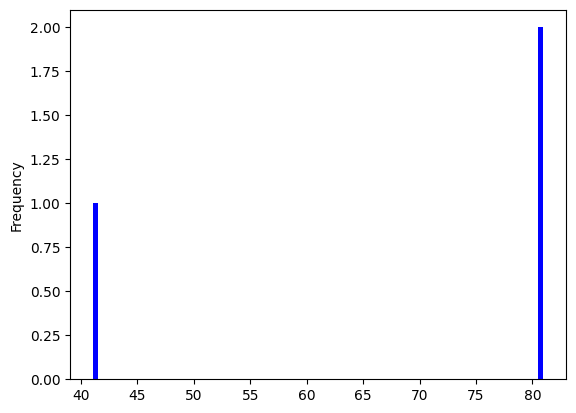

In [92]:
# # analysis on data
lulc_analysis_12['cover_2019'].plot.hist(bins=80,rwidth=0.9,
                    color='blue')

In [93]:
lulc_analysis_12[['cover_2019']].describe()

,cover_2019
count,3.000000
mean,67.666667
std,23.094011
min,41.000000
25%,61.000000
50%,81.000000
75%,81.000000
max,81.000000


In [94]:
lulc_analysis_12['cover_2019'].mode()

0    81
Name: cover_2019, dtype: int8

In [95]:
mesonet_single_datetime_df['elev'].iloc[0]

507.614

In [96]:
elevations = pp.elevation_bycoords(mesonet_lon_lat_list)
elevations

[507.606201171875,
 518.9600219726562,
 276.457275390625,
 90.07699584960938,
 469.9749755859375,
 144.83433532714844,
 417.7391357421875,
 394.8030090332031,
 533.6405029296875,
 8.627188682556152,
 218.6190643310547,
 184.0616912841797,
 169.1221466064453,
 40.87300109863281,
 504.93048095703125,
 120.59181213378906,
 179.6939697265625,
 567.8307495117188,
 97.01374816894531,
 150.3455352783203,
 84.27522277832031,
 56.776702880859375,
 330.2593688964844,
 424.1070861816406,
 583.8353271484375,
 191.034912109375,
 450.0195617675781,
 328.17718505859375,
 596.4066772460938,
 433.6776123046875,
 210.15748596191406,
 248.72010803222656,
 419.9256896972656,
 138.2196044921875,
 622.6011962890625,
 314.2943420410156,
 129.06048583984375,
 419.5341796875,
 377.123291015625,
 324.7904052734375,
 208.51959228515625,
 346.037109375,
 297.92236328125,
 333.2135925292969,
 55.65267562866211,
 179.1202392578125,
 238.9446258544922,
 535.9682006835938,
 98.79700469970703,
 255.94688415527344,
 39

In [97]:
# A large variance indicates that the data is spread out, - a small variance indicates that the data is clustered closely around the mean.
statistics.pvariance(elevations)

33306.39754298322

In [98]:
statistics.pstdev(elevations)

182.5004042269036

In [99]:
statistics.mode(elevations)

507.606201171875

In [100]:
statistics.mean(elevations)

291.30432608014064

In [101]:
# For normally distributed data, the skewness should be about zero. For unimodal continuous distributions, a skewness value greater than zero means that there is more weight in the right tail of the distribution. 

skew(elevations)

0.2740142672725978

In [102]:
max(elevations)

729.56494140625

In [103]:
min(elevations)

8.430109977722168